In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

import random
import os

In [99]:
def extract_file_name(path):
    return path.split('\\')[-1]

In [100]:
def read_driving_csv(csv_path:str):
    with open(csv_path, 'r') as f:
        df = pd.read_csv(
            csv_path,
            header=None,
            names=['center', 'left', 'right', 'steering_angle'],
            usecols=[0, 1, 2, 3],
            converters={
                'center': lambda x: extract_file_name(x),
                'left': lambda x: extract_file_name(x),
                'right': lambda x: extract_file_name(x)
            }
        )

        return df

In [101]:
def all_three_views_exist(paths):
    return all([os.path.exists(path) for path in paths])

In [102]:
data_dir_folders = ['good 1', 'good 2']
remove_indexes = []

for folder in data_dir_folders:
    print('-- Checking {0}'.format(folder))
    csv_path = '.\\data\\{0}\\driving_log.csv'.format(folder)

    df = read_driving_csv(csv_path)
    print('DF Before: ', len(df))

    for index, row in df.iterrows():
        image_center_path = '.\\data\\{0}\\IMG\\{1}'.format(folder, row['center'])
        image_left_path = '.\\data\\{0}\\IMG\\{1}'.format(folder, row['left'])
        image_right_path = '.\\data\\{0}\\IMG\\{1}'.format(folder, row['right'])

        # if file does not exist
        if not all_three_views_exist([image_center_path, image_left_path, image_right_path]):
            for path in [image_center_path, image_left_path, image_right_path]:
                if os.path.exists(path):
                    os.remove(path)

            remove_indexes.append(index)

    df.drop(labels=df.index[remove_indexes], inplace=True)
    print('DF After : ', len(df))
    df.to_csv(csv_path, index=False, header=False)

-- Checking good 1
DF Before:  10405
DF After :  10405
-- Checking good 2
DF Before:  20882
DF After :  20882


In [103]:
# import sys
# sys.getsizeof(element['center']) * 3 * len(full_set)

# Data Augmentation

In [104]:
full_set = pd.DataFrame()

for folder in data_dir_folders:
    df = read_driving_csv('.\\data\\{0}\\driving_log.csv'.format(folder))
    full_set = pd.concat([full_set, df], ignore_index=True)

len(full_set)

31287

In [105]:
full_set.head()

,center,left,right,steering_angle
0,center_2019_04_02_19_25_35_023.jpg,left_2019_04_02_19_25_35_023.jpg,right_2019_04_02_19_25_35_023.jpg,0.00
1,center_2019_04_02_19_25_35_092.jpg,left_2019_04_02_19_25_35_092.jpg,right_2019_04_02_19_25_35_092.jpg,-0.15
2,center_2019_04_02_19_25_35_164.jpg,left_2019_04_02_19_25_35_164.jpg,right_2019_04_02_19_25_35_164.jpg,0.00
3,center_2019_04_02_19_25_35_232.jpg,left_2019_04_02_19_25_35_232.jpg,right_2019_04_02_19_25_35_232.jpg,0.00
4,center_2019_04_02_19_25_35_303.jpg,left_2019_04_02_19_25_35_303.jpg,right_2019_04_02_19_25_35_303.jpg,0.00


<Axes: ylabel='Frequency'>

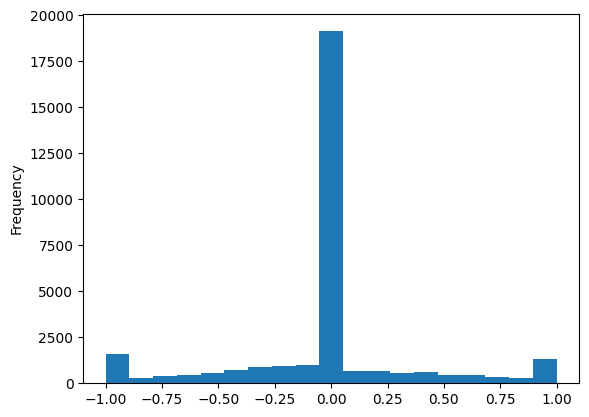

In [106]:
full_set['steering_angle'].plot.hist(bins=19)

# Too Many 0 Steering Rows!

In [111]:
num_bins = 21
samples_per_bin = 900

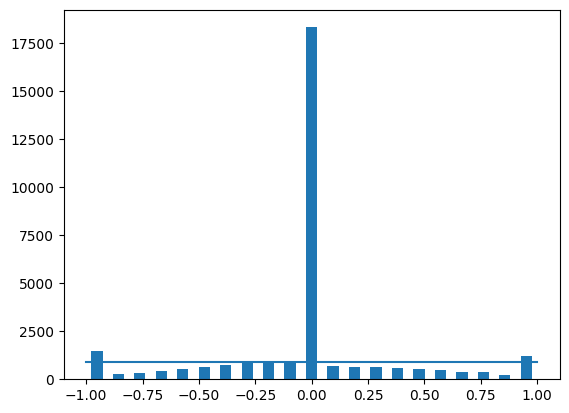

In [112]:
hist, bins = np.histogram(full_set['steering_angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(full_set['steering_angle']), np.max(full_set['steering_angle'])), (samples_per_bin, samples_per_bin))

In [113]:
print('total data:', len(full_set))
remove_list = []

for j in range(num_bins):
  list_ = []
  for i in range(len(full_set['steering_angle'])):
    if bins[j] <= full_set['steering_angle'][i] <= bins[j + 1]:
      list_.append(i)

  random.shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
full_set.drop(full_set.index[remove_list], inplace=True)
print('remaining:', len(full_set))

total data: 31287
removed: 18450
remaining: 12837


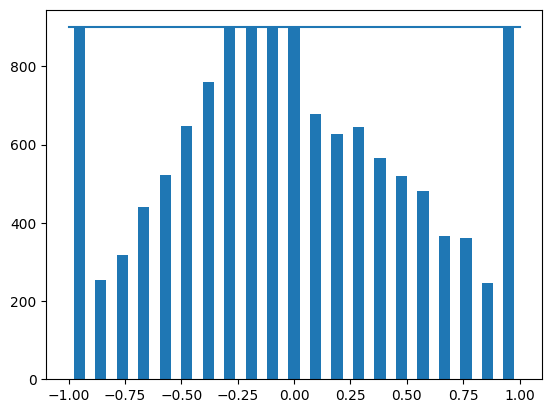

In [114]:
hist, _ = np.histogram(full_set['steering_angle'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(full_set['steering_angle']), np.max(full_set['steering_angle'])), (samples_per_bin, samples_per_bin))

In [116]:
from collections import Counter

c = Counter()
for index, sim_data in full_set.iterrows():
    if -0.2 <= sim_data['steering_angle'] <= 0.2:
        c['straight'] += 1
    elif sim_data['steering_angle'] > 0.2:
        c['right'] += 1
    else:
        c['left'] += 1

c

Counter({'straight': 4005, 'left': 4745, 'right': 4087})

# Splitting Dataset

In [117]:
from sklearn.model_selection import train_test_split
# 70-20-10 cuts
X_train, X_test = train_test_split(full_set, train_size=0.9, shuffle=True)

<Axes: ylabel='Frequency'>

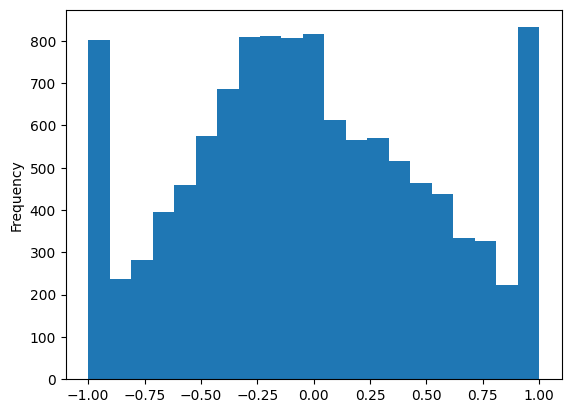

In [118]:
X_train['steering_angle'].plot.hist(bins=21)

In [143]:
X_train.to_csv('.\\data\\driving_train_log.csv', index=False)
X_test.to_csv('.\\data\\driving_test_log.csv', index=False)